In [10]:
import torch
import torch.utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [11]:
class Theta(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        y = self.layer1(x)
        y = F.relu(y)
        y = self.layer2(x)
        return y

In [12]:
class Psi(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer_mu = nn.Linear(hidden_dim, output_dim)
        self.layer_sigma = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        y = self.layer1(x)
        y = F.relu(y)
        mu = self.layer_mu(y)
        sigma = torch.exp(self.layer_sigma(y)/2)
        return mu, sigma

In [13]:
class VAEModel(nn.Module):
    def __init__(self, data_dim, latent_dim, theta_hidden_dim, phi_hidden_dim):
        super().__init__()
        self.theta = Theta(latent_dim, theta_hidden_dim, data_dim)
        self.psi = Psi(data_dim, phi_hidden_dim, latent_dim)
        self.latent_dim = latent_dim

    def get_loss(self, x):
        mu, sigma = self.psi(x)
        e = torch.randn(len(x), self.latent_dim)
        z = sigma*e + mu
        x_hat = self.theta(z)
        f1 = F.mse_loss(x, x_hat, reduction='sum')
        var = sigma**2
        f2 = -(1 + torch.log(var) - mu**2 - var).sum()
        return f1 + f2
    
    def generate(self, n=1, return_hat=False):
        z = torch.randn(n, self.latent_dim)
        x_hat = self.theta(z)
        if return_hat:
            return x_hat
        else:
            return x_hat + torch.randn(x_hat.shape)
    
    def decode(self, z):
        return self.theta(z)


In [14]:
batch_size = 200
latent_dim = 5
hidden_dim = 100
epoch_num = 50

In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


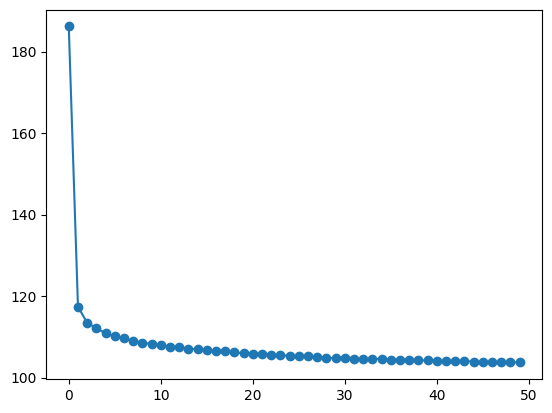

In [16]:
torch.random.manual_seed(0)

vae_model = VAEModel(len(dataset[0][0]), latent_dim, hidden_dim, hidden_dim)
optimizer = torch.optim.Adam(vae_model.parameters())
loss_sum_rec = []

for epoch in range(epoch_num):
    loss_sum_rec.append(0)
    for x, label in dataloader:
        loss = vae_model.get_loss(x)
        loss_sum_rec[-1] += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    loss_sum_rec[-1] /= len(dataset)
    plt.clf()
    plt.plot(range(len(loss_sum_rec)), loss_sum_rec, marker='o')
    plt.pause(0.00001)
    clear_output(wait=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45780903..1.2726065].


(np.float64(-0.5), np.float64(545.5), np.float64(545.5), np.float64(-0.5))

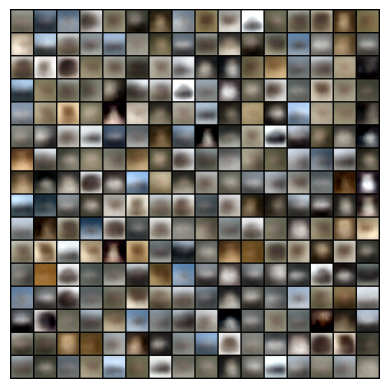

In [17]:
sample_num = 256
with torch.no_grad():
    x = vae_model.generate(sample_num, True)
    generated_imgs = x.view(sample_num, 3, 32, 32)

grid_img = torchvision.utils.make_grid(
    generated_imgs,
    nrow=16,
    padding=2,
    #normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26244164..1.020217].


(np.float64(-0.5), np.float64(273.5), np.float64(273.5), np.float64(-0.5))

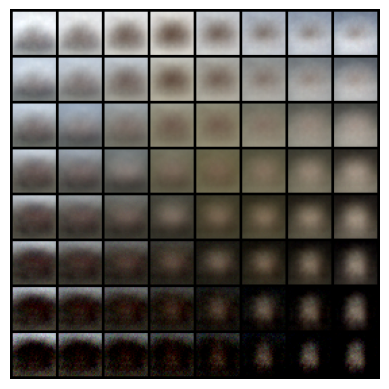

In [211]:
with torch.no_grad():
    z0 = torch.linspace(-1.5, 1.5, 8)
    z1 = torch.linspace(-1.5, 1.5, 8)
    z0, z1 = torch.meshgrid([z0, z1])
    z0 = z0.flatten()
    z1 = z1.flatten()
    z = torch.vstack([z0, z1]).transpose(1, 0)
    x = vae_model.decode(z)
    generated_imgs = x.view(64, 3, 32, 32)

grid_img = torchvision.utils.make_grid(
    generated_imgs,
    nrow=8,
    padding=2,
    #normalize=True
)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')